## Problem Set 5

### Joseph Denby

In [178]:
import numpy as np
import pandas as pd
import numpy.linalg as lin

import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
from scipy.interpolate import LSQUnivariateSpline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
cmap1 = matplotlib.cm.get_cmap('summer')
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm


### Problem 1

In [33]:
drinks = pd.read_csv('../../../ProblemSets/PS5/data/strongdrink.txt')

In [43]:
drinks['const'] = 1

In [54]:
drinks.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline,const
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


a). Use a multinomial logistic regression model of the following form with the following linear predictor $\eta_j$ for $j$ = 1, 2 (the baseline class is $j$ = 3).

$Pr(cultivar_i = j|X\beta_j) = \frac{e^{\eta_j}}{1+\sum^{J-1}_{j=1}e^{\eta_j}}$ for $j = 1,2$

$\eta_j = \beta_{j,0} + \beta_{j,1} alco_i + \beta_{j,2} malic_i + \beta_{j,3} tot\_phen_i + \beta_{j,4} color\_int_i$

In [57]:
drinks.cultivar.value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

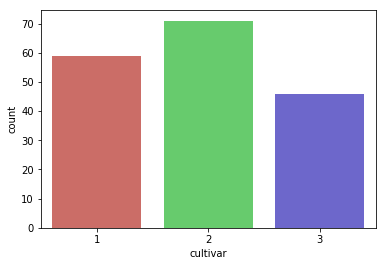

In [117]:
sns.countplot(x='cultivar', data=drinks, palette='hls')

In [45]:
X = drinks[['const', 'alco', 'malic', 'tot_phen', 'color_int']]
y = drinks[['cultivar']]

In [78]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.25,
       random_state=20)

In [79]:
MultLogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
MultLogReg.fit(X_train, y_train)

/Users/josephdenby/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [80]:
y_pred = MultLogReg.predict(X_test)

Using the classification report, we can observe the precision values for each category.

In [81]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



Understanding the error rate ($\epsilon_j$) to be $1 - precision_j$:

$\epsilon_1 = 1 - .87 = .13$   
$\epsilon_2 = \epsilon_3 = 1 - 1 = 0$

For $j = 1$, $\vec{\beta}$:

In [52]:
MultLogReg.coef_[0]

array([-8.45998034e-06,  1.70038994e+00, -2.65604001e-01,  1.22389318e+00,
        2.27585993e-02])

For $j = 2$, $\vec{\beta}$:

In [53]:
MultLogReg.coef_[1]

array([-1.76923783e-05, -1.46805313e+00, -3.33053748e-01,  6.64013944e-01,
       -9.22712974e-01])

Based on the classification report, this model performs with perfect precision when predicting members of categories $j = 2$ and $j=3$. According to the countplot above, these categories have the most ($n=71$) and fewest ($n = 46$) observations respectively.

b). Perform a leave-one-out cross validation (LOOCV) with the model from part (a). Report your error rates (1 - precision) for each category. How do your error rates compare to those from part (a)? Report your LOOCV estimate for the test MSE as the average MSE, where $y_i$ is the left out observation from each test set.

$CV_{loo} = \frac{1}{N} \sum^{N}_{i=1}MSE_i = \frac{1}{N} \sum^{N}_{i=1}[1-I(y_i = \hat{y}_i)]$

In [58]:
from sklearn.model_selection import LeaveOneOut

In [84]:
Xvals = X.values
yvals = y.values
N_loo = Xvals.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvals)
MSE_vec = np.zeros(N_loo)

In [85]:
ytests = np.zeros(N_loo)
ypreds = np.zeros(N_loo)
for train_index, test_index in loo.split(Xvals):
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    ytests[test_index] = y_test
    MultLogReg = LogisticRegression(multi_class='multinomial',solver='newton-cg')
    MultLogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    ypreds[test_index] = y_pred
    MSE_vec[test_index] = (y_test - y_pred) ** 2
    print('MSE for test set', test_index, ' is', MSE_vec[test_index])

MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('test estimate MSE loocv=', MSE_loo,
      ', test estimate MSE standard err=', MSE_loo_std)
    

/Users/josephdenby/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE for test set [0]  is [0.]
MSE for test set [1]  is [0.]
MSE for test set [2]  is [0.]
MSE for test set [3]  is [0.]
MSE for test set [4]  is [0.]
MSE for test set [5]  is [0.]
MSE for test set [6]  is [0.]
MSE for test set [7]  is [0.]
MSE for test set [8]  is [0.]
MSE for test set [9]  is [0.]
MSE for test set [10]  is [0.]
MSE for test set [11]  is [0.]
MSE for test set [12]  is [0.]
MSE for test set [13]  is [0.]
MSE for test set [14]  is [0.]
MSE for test set [15]  is [0.]
MSE for test set [16]  is [0.]
MSE for test set [17]  is [0.]
MSE for test set [18]  is [0.]
MSE for test set [19]  is [0.]
MSE for test set [20]  is [0.]
MSE for test set [21]  is [0.]
MSE for test set [22]  is [1.]
MSE for test set [23]  is [1.]
MSE for test set [24]  is [1.]
MSE for test set [25]  is [1.]
MSE for test set [26]  is [0.]
MSE for test set [27]  is [1.]
MSE for test set [28]  is [0.]
MSE for test set [29]  is [0.]
MSE for test set [30]  is [0.]
MSE for test set [31]  is [0.]
MSE for test set [

In [88]:
print(classification_report(ytests, ypreds))

             precision    recall  f1-score   support

        1.0       0.84      0.83      0.84        59
        2.0       0.85      0.89      0.87        71
        3.0       0.98      0.93      0.96        46

avg / total       0.88      0.88      0.88       176



Yikes! LOOCV leads to worse performance overall.


$\epsilon_1 = 1-.84 = .16$   
$\epsilon_2 = 1-.85 = .15$   
$\epsilon_3 = 1-.98 = .2$

c). Perform a $k$-fold cross validation in which the data are divided into $k$ = 4 groups. Use the following code. Report your error rates (1 - precision) for each category. How do your error rates compare to those from parts (a) and (b)? Report your $k$-fold estimate for the test MSE as the average MSE.

In [93]:
from sklearn.model_selection import KFold
k = 4
kf = KFold(n_splits=k, shuffle=True, random_state=10)
kf.get_n_splits(X)

4

In [101]:
MSE_vec_kf = np.zeros(k)
ytests = np.array([])
ypreds = np.array([])
k_ind = int(0)
for train_index, test_index in kf.split(Xvals):
    # print("TRAIN:", train_index, "TEST:", test_index)
    print('k index=', k_ind)
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    ytests = np.append(ytests, y_test)
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    ypreds = np.append(ypreds, y_pred)
    MSE_vec_kf[k_ind] = ((y_test - y_pred) ** 2).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

k index= 0
MSE for test set 0  is 1.012396694214876
k index= 1
MSE for test set 1  is 1.3233471074380165
k index= 2
MSE for test set 2  is 1.1818181818181819
k index= 3
MSE for test set 3  is 1.0537190082644627
test estimate MSE k-fold= 1.1428202479338843 test estimate MSE standard err= 0.12151143991924328


/Users/josephdenby/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [102]:
print(classification_report(ytests, ypreds))

             precision    recall  f1-score   support

        1.0       0.81      0.75      0.78        59
        2.0       0.81      0.87      0.84        71
        3.0       0.96      0.93      0.95        46

avg / total       0.85      0.85      0.85       176



Performance is worse still!

$\epsilon_1 = 1-.81 = .19$   
$\epsilon_2 = 1-.81 = .19$   
$\epsilon_3 = 1-.96 = .04$

### Problem 2

In [112]:
cool = pd.read_csv('../../../ProblemSets/PS5/data/CoolIndex.txt', header=None)
cool = cool.rename(columns={0:'age', 1:'coolindex'})

In [114]:
cool.head()

,age,coolindex
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


a). Create a scatterplot of the data with $age$ on the $x$-axis and $Coolness\ Index$ on the $y$-axis. Label your axes, and give the plot a title.

Text(0,0.5,'Coolness Index')

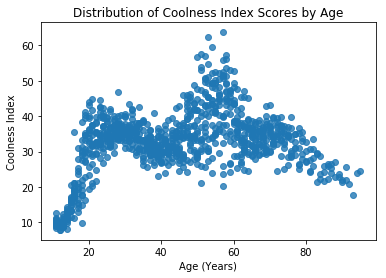

In [122]:
ax = plt.axes()
sns.regplot(x=cool["age"], y=cool["coolindex"], fit_reg=False, ax=ax)
ax.set_title('Distribution of Coolness Index Scores by Age')
ax.set_xlabel('Age (Years)')
ax.set_ylabel('Coolness Index')

b). Use ordinary least squares (OLS) regression to fit a stepwise function to these data. Use 5 bins [11, 22), [22, 40), [40, 59), [59, 77), [77, 95]. Remember that your dummy variables must be integer type (0, 1), not boolean type (True, False). Plot this step function on top of the scatterplot of the data from part (a). Label your axes, include a legend, and give the plot a title. Report your estimated step function values for each bin
[$\beta_1, \beta_2, \beta_3, \beta_4, \beta_5$]. What is the predicted coolness of a 73-year old from the stepwise function?

In [125]:
index = cool['coolindex']
age = cool['age']
age_bin1 = ((age >= 11) & (age < 22)).astype(int)
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = ((age >= 77) & (age <= 95)).astype(int)
X_step = pd.DataFrame(dict(age_bin1=age_bin1, age_bin2=age_bin2,
                           age_bin3=age_bin3, age_bin4=age_bin4,
                           age_bin5=age_bin5))

In [128]:
reg = sm.OLS(endog=index, exog=X_step, missing='drop')
reg_results = reg.fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:              coolindex   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Fri, 16 Feb 2018   Prob (F-statistic):          3.73e-114
Time:                        12:33:28   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_bin1      20.1025      0.562     35.746      0.0

In the summary above, the `coef` column indicates the step function values for each bin.

In [169]:
x = [11, 22, 40, 59, 77, 95]
y = reg_results.params.tolist() + [reg_results.params[-1]]

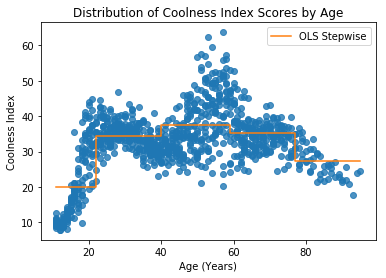

In [173]:
ax = plt.axes()
sns.regplot(x=cool["age"], y=cool["coolindex"], fit_reg=False, ax=ax)
ax.set_title('Distribution of Coolness Index Scores by Age')
ax.set_xlabel('Age (Years)')
ax.set_ylabel('Coolness Index')
ax.plot()

plt.step(x,y, where = 'post', label = 'OLS Stepwise')
plt.legend()

A 73 year-old falls within the fourth bin given to the model, which, in turns, predicts a Coolness Index score of 35.2254.

c). Fit a linear spline (continuous) to the data over the 5 age bins from part (b). Use the `scipy.interpolate.LQUnivariateSpline` function with `k` = 1 (linear) and the knots equal to `t =[22,40,59,77]`. Plot your continuous linear spline against a scatterplot of the data from part (a) and the estimated step function from part (b). Label your axes, include a legend, and give the plot a title. What is the predicted coolness of a 73-year old from the linear spline?

In [186]:
age.values.unique

TypeError: 'numpy.ndarray' object is not callable

In [183]:
t = [22, 40, 59, 77]
k = 1

spl_index = LSQUnivariateSpline(uniq(age.values), index.values, t, k )




ValueError: x must be strictly increasing

d). Fit a cubic spline (continuous) to the data over the 5 age bins from part (b). Use the `scipy.interpolate.LQUnivariateSpline` function with $k = 3$ (cubic) and the knots equal to $t$ =`[22,40,59,77]`. Plot your continuous cubic spline against a scatterplot of the data from part (a) and the estimated step function from part (b), and the linear spline from part (c). Label your axes, include a legend, and give the plot a title. What is the predicted coolness of a 73-year old from the cubic spline?

In [ ]:
spl_index = LSQUnivariateSpline(sorted(age.values), index.values, t, k )
